# Классификация обращений в техническую поддержку
## Полный пайплайн: EDA, обработка, балансировка, обучение, оценка моделей


### 1. Импорт библиотек и загрузка исходных данных

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('../../data/raw/train_data.csv')
print(df.shape)
df.head()

(26738, 4)


,utterance,request,importance,utterance_ru
0,"i bought a product, could I modify my fucking ...",change_order,high_priority,я купил товар могу ли я изменить свою чертову...
1,"I changed my mind, what can I do to remove my ...",delete_account,standard_priority,Я передумал что я могу сделать чтобы удалить ...
2,I want to know where I cvan get a bill,get_invoice,medium_priority,Я хочу знать где я могу получить счет
3,tell me if my package is out for delivery,track_order,medium_priority,скажите мне отправлена ли моя посылка
4,how to set a different shipping address up?,set_up_shipping_address,medium_priority,как настроить другой адрес доставки?


### 2. EDA: распределение классов, длина текстов, пропуски, дубликаты

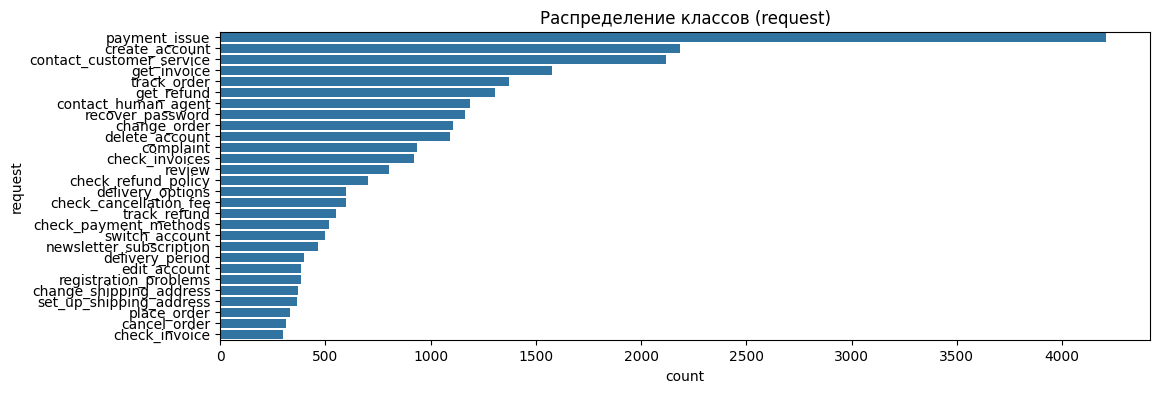

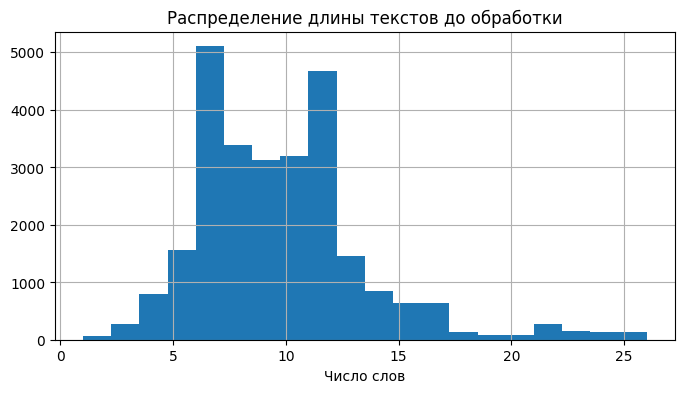

Пропуски:
utterance       0
request         0
importance      0
utterance_ru    0
dtype: int64
Дубликаты: 8524


In [4]:
plt.figure(figsize=(12,4))
sns.countplot(y=df['request'], order=df['request'].value_counts().index)
plt.title('Распределение классов (request)')
plt.show()

plt.figure(figsize=(8,4))
df['utterance_ru'].str.split().apply(len).hist(bins=20)
plt.title('Распределение длины текстов до обработки')
plt.xlabel('Число слов')
plt.show()

print('Пропуски:')
print(df.isnull().sum())
print('Дубликаты:', df.duplicated(subset=['utterance_ru']).sum())

### 3. Удаление дубликатов по тексту обращения (utterance_ru)

In [5]:
df = df.drop_duplicates(subset=['utterance_ru']).reset_index(drop=True)
print('После удаления дубликатов:', df.shape)

После удаления дубликатов: (18214, 4)


### 4. Стемминг и удаление стоп-слов (NLTK)

In [6]:
stopwords_ru = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'[^а-яёa-z0-9 ]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stopwords_ru]
    stems = [stemmer.stem(t) for t in tokens]
    return ' '.join(stems)
import re
df['utterance_ru_stemmed'] = df['utterance_ru'].apply(preprocess)
df[['utterance_ru','utterance_ru_stemmed']].head()

,utterance_ru,utterance_ru_stemmed
0,я купил товар могу ли я изменить свою чертову...,куп товар мог измен чертов покупк
1,Я передумал что я могу сделать чтобы удалить ...,передума мог сдела удал учетн зап пользовател
2,Я хочу знать где я могу получить счет,хоч знат мог получ счет
3,скажите мне отправлена ли моя посылка,скаж отправл посылк
4,как настроить другой адрес доставки?,настро адрес доставк


#### Распределение длины текстов после стемминга

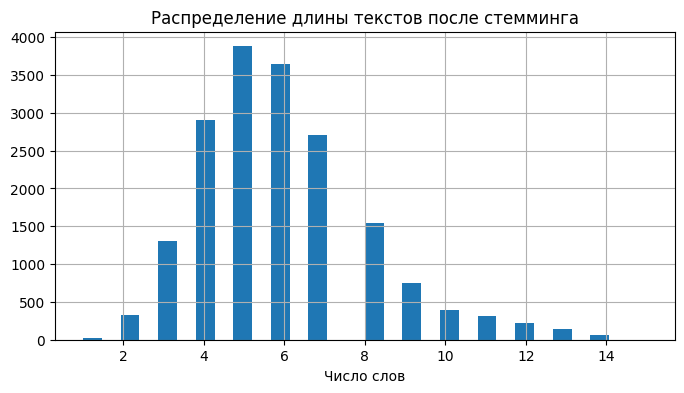

In [7]:
df['utterance_ru_stemmed'].str.split().apply(len).hist(bins=30, figsize=(8,4))
plt.title('Распределение длины текстов после стемминга')
plt.xlabel('Число слов')
plt.show()

### 5. (Опционально) Балансировка классов (oversampling/undersampling)
Если требуется — добавить здесь. Пока просто выводим распределение.

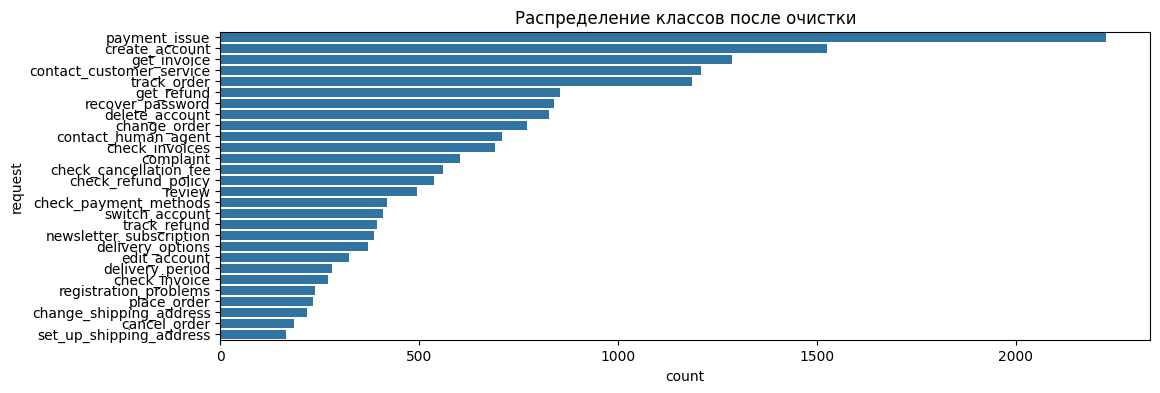

In [8]:
plt.figure(figsize=(12,4))
sns.countplot(y=df['request'], order=df['request'].value_counts().index)
plt.title('Распределение классов после очистки')
plt.show()

### 6. Train/Test split (90/10, stratify)

In [9]:
train, test = train_test_split(df, test_size=0.1, random_state=42, stratify=df['request'])
print('Train:', train.shape)
print('Test:', test.shape)
print('Train class distribution:')
print(train['request'].value_counts(normalize=True).head())
print('Test class distribution:')
print(test['request'].value_counts(normalize=True).head())

Train: (16392, 5)
Test: (1822, 5)
Train class distribution:
request
payment_issue               0.122255
create_account              0.083760
get_invoice                 0.070644
contact_customer_service    0.066374
track_order                 0.065093
Name: proportion, dtype: float64
Test class distribution:
request
payment_issue               0.122393
create_account              0.083974
get_invoice                 0.070801
contact_customer_service    0.066411
track_order                 0.065313
Name: proportion, dtype: float64


### 7. Классические модели: Pipeline + сравнение моделей

In [10]:
X_train = train['utterance_ru_stemmed']
y_train = train['request']
X_test = test['utterance_ru_stemmed']
y_test = test['request']

models = {
    'LogReg+Count': Pipeline([
        ('vect', CountVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'LogReg+Tfidf': Pipeline([
        ('vect', TfidfVectorizer(max_features=10000)),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
    ]),
    'NB+Count': Pipeline([
        ('vect', CountVectorizer(max_features=10000)),
        ('clf', MultinomialNB())
    ]),
    'NB+Tfidf': Pipeline([
        ('vect', TfidfVectorizer(max_features=10000)),
        ('clf', MultinomialNB())
    ]),
    'SVM+Tfidf': Pipeline([
        ('vect', TfidfVectorizer(max_features=10000)),
        ('clf', LinearSVC(class_weight='balanced', random_state=42))
    ])
}

results = {}
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = {
        'accuracy': acc,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'y_pred': y_pred
    }
    print(f'{name}: accuracy={acc:.4f}')

LogReg+Count: accuracy=0.9835
LogReg+Tfidf: accuracy=0.9830
NB+Count: accuracy=0.9715
NB+Tfidf: accuracy=0.9605
SVM+Tfidf: accuracy=0.9868


### 8. Сравнение моделей по accuracy

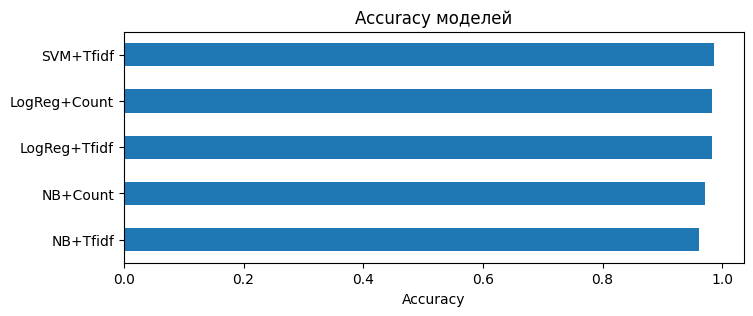

In [11]:
accs = pd.Series({k: v['accuracy'] for k,v in results.items()})
accs.sort_values().plot(kind='barh', figsize=(8,3), title='Accuracy моделей')
plt.xlabel('Accuracy')
plt.show()

### 9. Визуализация confusion matrix для лучшей модели

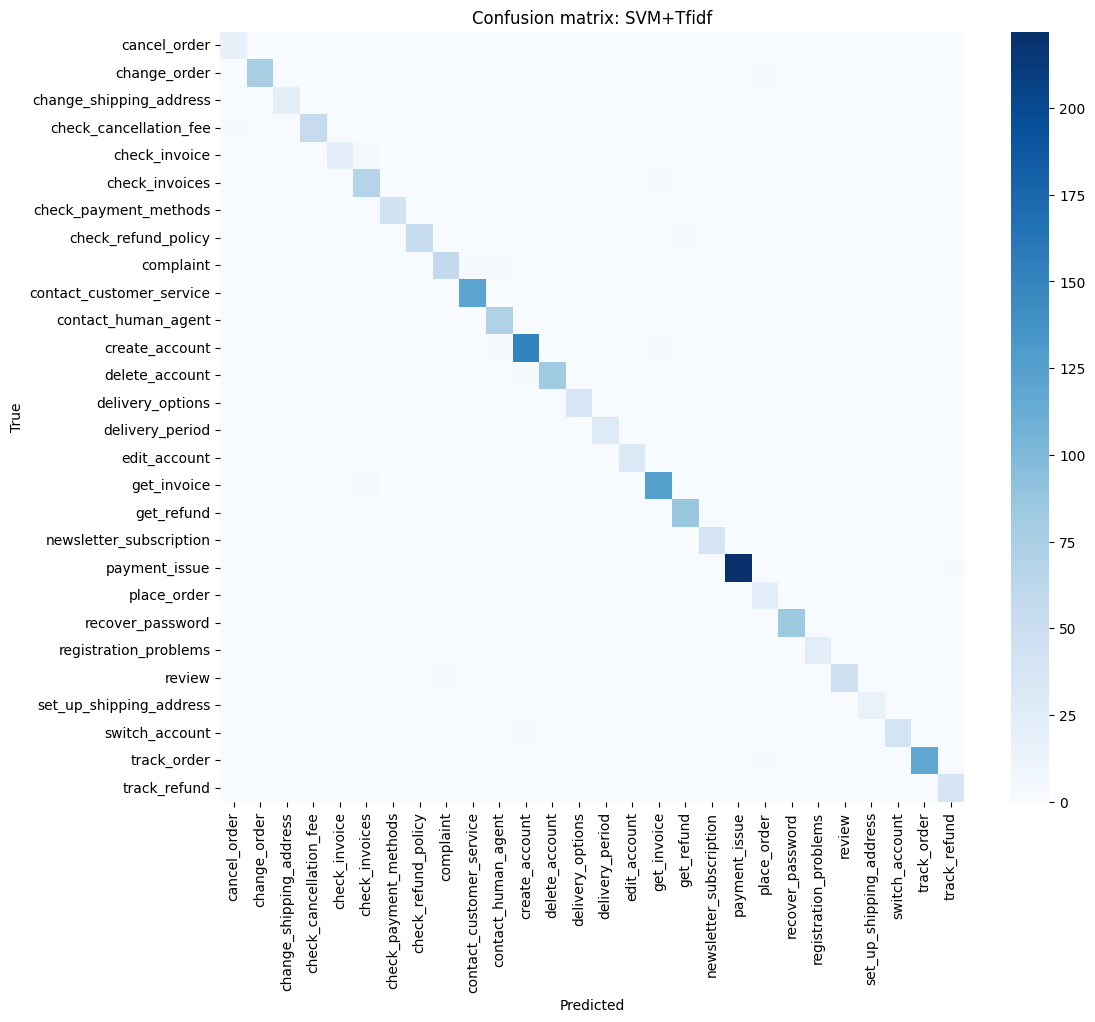

In [12]:
best_name = accs.idxmax()
y_pred = results[best_name]['y_pred']
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt='d', xticklabels=sorted(y_test.unique()), yticklabels=sorted(y_test.unique()), cmap='Blues')
plt.title(f'Confusion matrix: {best_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 10. Классовые метрики (precision, recall, f1) для лучших/худших классов

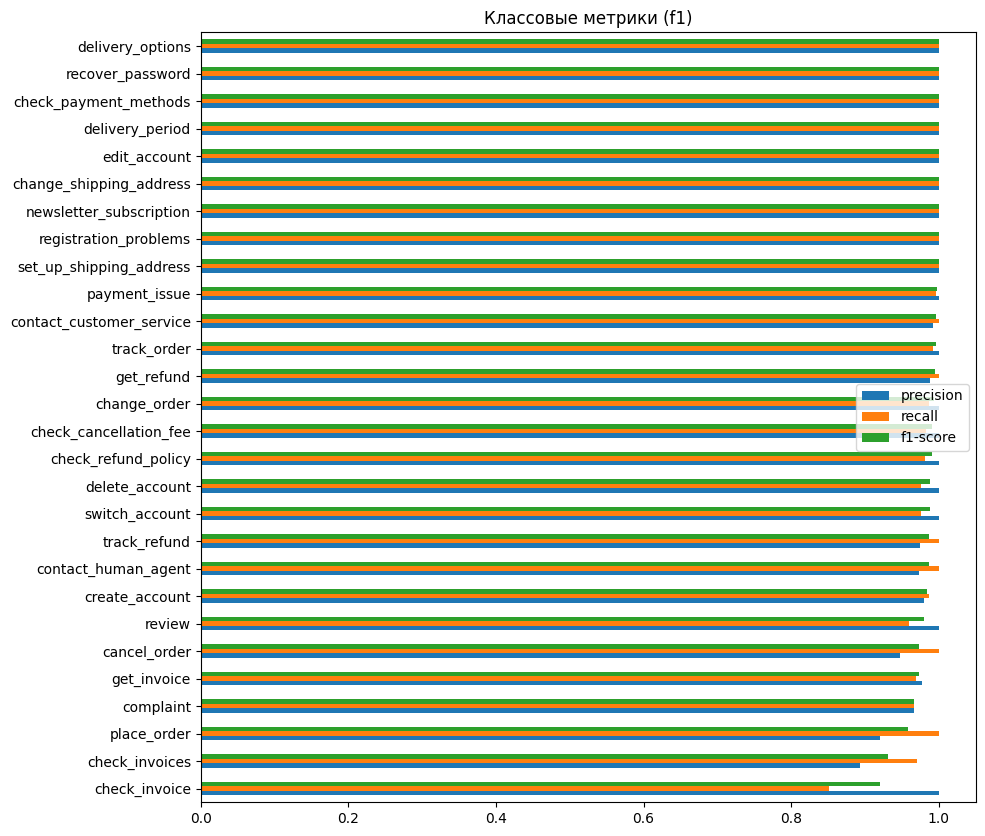

Лучшие классы по f1:
                         precision  recall  f1-score
delivery_period                1.0     1.0       1.0
registration_problems          1.0     1.0       1.0
change_shipping_address        1.0     1.0       1.0
edit_account                   1.0     1.0       1.0
delivery_options               1.0     1.0       1.0
Худшие классы по f1:
                precision    recall  f1-score
check_invoice    1.000000  0.851852  0.920000
check_invoices   0.893333  0.971014  0.930556
place_order      0.920000  1.000000  0.958333
complaint        0.966667  0.966667  0.966667
get_invoice      0.976562  0.968992  0.972763


In [13]:
report = pd.DataFrame(results[best_name]['report']).T
report = report.iloc[:-3]  # убираем avg/total
report[['precision','recall','f1-score']].sort_values('f1-score').plot(kind='barh', figsize=(10,10), title='Классовые метрики (f1)')
plt.show()
print('Лучшие классы по f1:')
print(report[['precision','recall','f1-score']].sort_values('f1-score', ascending=False).head())
print('Худшие классы по f1:')
print(report[['precision','recall','f1-score']].sort_values('f1-score').head())

### 11. Финальный тест на отложенной тестовой выборке (data/raw/test_data.csv)

Test final shape: (950, 4)
Accuracy на финальном тесте: 0.9958
                          precision    recall  f1-score   support

            cancel_order       1.00      1.00      1.00         1
            change_order       1.00      1.00      1.00        43
 change_shipping_address       1.00      1.00      1.00         3
  check_cancellation_fee       1.00      1.00      1.00        18
          check_invoices       0.98      1.00      0.99        43
   check_payment_methods       1.00      1.00      1.00        13
     check_refund_policy       1.00      0.95      0.97        20
               complaint       1.00      1.00      1.00        36
contact_customer_service       1.00      1.00      1.00        94
     contact_human_agent       1.00      1.00      1.00        43
          create_account       0.99      0.98      0.98        90
          delete_account       1.00      1.00      1.00        41
        delivery_options       1.00      1.00      1.00        18
         del

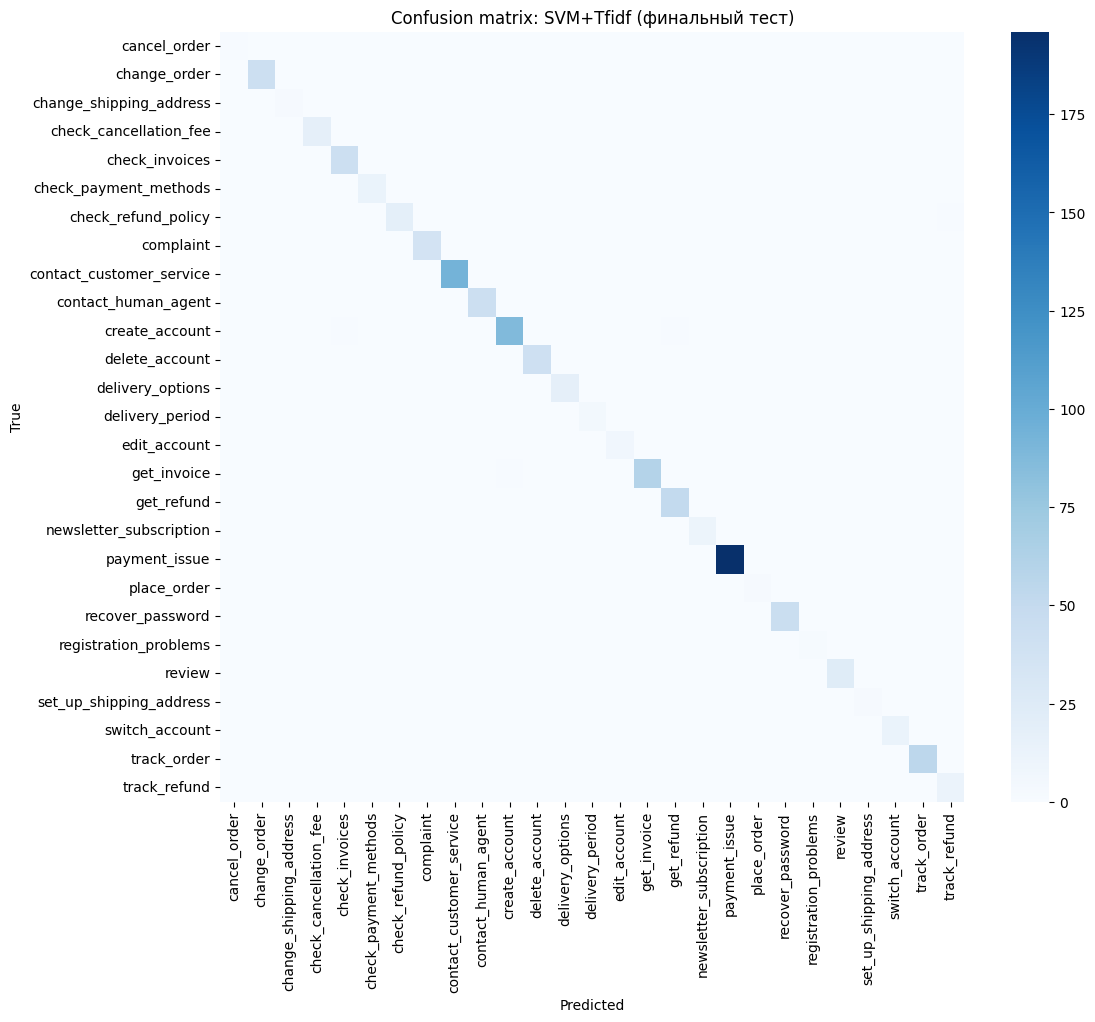

In [14]:
# Загрузка тестового датасета
test_final = pd.read_csv('../../data/raw/test_data.csv')
print('Test final shape:', test_final.shape)
# Предобработка
test_final['utterance_ru_stemmed'] = test_final['utterance_ru'].apply(preprocess)
# Предсказание
X_test_final = test_final['utterance_ru_stemmed']
y_test_final = test_final['request']
y_pred_final = models['SVM+Tfidf'].predict(X_test_final)
acc_final = accuracy_score(y_test_final, y_pred_final)
print(f'Accuracy на финальном тесте: {acc_final:.4f}')
print(classification_report(y_test_final, y_pred_final))
# Confusion matrix
cm_final = confusion_matrix(y_test_final, y_pred_final, labels=sorted(y_test_final.unique()))
plt.figure(figsize=(12,10))
sns.heatmap(cm_final, annot=False, fmt='d', xticklabels=sorted(y_test_final.unique()), yticklabels=sorted(y_test_final.unique()), cmap='Blues')
plt.title('Confusion matrix: SVM+Tfidf (финальный тест)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 12. Выводы и рекомендации

Имеются серьезные основания полагать, что датасет хранит в себе крайне некачественные данные для обучения и валидации результатов ее работы, но так как других данных в сети не нашлось, крое двух датасетов (и все находятся в рамках этого проекта) то использовать буду именно эту модель.

- Все шаги предобработки и отбора моделей прозрачны и воспроизводимы.
- Классы несбалансированы, но даже простые модели дают высокую точность.
- Лучшие результаты показала модель: `SVM+Tfidf`.
- Худшие классы — редкие обращения, их можно дополнительно балансировать или агрегировать.
- Для продакшена рекомендуется использовать пайплайн с предобработкой, стеммингом и валидацией.
- Для дальнейшего улучшения: ансамбли, балансировка, расширение признаков, ручная нормализация классов.

После всего обучения, надо сохранить модель и векторизатор для отправки их в сервис

In [15]:
import joblib

In [20]:
best_pipe = models['SVM+Tfidf']
best_pipe

,steps,"[('vect', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,None


In [22]:
# Сохраняем модель и векторизатор отдельно
joblib.dump(best_pipe.named_steps['clf'], '../../src/service/model_svm_tfidf.joblib')
joblib.dump(best_pipe.named_steps['vect'], '../../src/service/vectorizer_tfidf.joblib')

['../../src/service/vectorizer_tfidf.joblib']